# Контекст
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

# Часть 1. Приоритизация гипотез.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats

In [2]:
register_matplotlib_converters()

In [3]:
data = pd.read_csv('hypothesis.csv')

In [4]:
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Заменим название столбцов, приведем к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()

## ICE

Посчитаем ICE для гипотез. Отсортируем их по убыванию приоритета.

In [6]:
data['ICE'] = data['impact']*data['confidence']/data['efforts']

In [7]:
data_ice = data.loc[:,['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

In [8]:
print(data_ice)

                                          hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


Наиболее перспективны гипотезы по ICE: 8, 0, 7, 6.

## RICE

Посчитаем RICE для гипотез. Отсортируем их по убыванию приоритета.

In [9]:
data['RICE'] = data['reach']*data['impact']*data['confidence']/data['efforts']

In [10]:
data_rice = data.loc[:,['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

In [11]:
print(data_rice)

                                          hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Наиболее перспективны гипотезы по RICE: 7, 2, 0, 6.

С изменением метода изменился порядке приоретизации гипотез и гипотеза 8 заменилась на гипотезу 2.
Гипотеза 7 вышла на первое место так как параметр reach равен 10, а у остальных он меньше. Также из-за параметра reach гипотеза 8 (reach=1) заменилась на гипотизу 2 (reach=8).

## Вывод
- Наиболее перспективны гипотезы по ICE: 8, 0, 7, 6.
- Наиболее перспективны гипотезы по RICE: 7, 2, 0, 6.
- С изменением метода изменился порядке приоретизации гипотез и гипотеза 8 заменилась на гипотезу 2. Гипотеза 7 вышла на первое место так как параметр reach равен 10, а у остальных он меньше. Также из-за параметра reach гипотеза 8 (reach=1) заменилась на гипотизу 2 (reach=8).

# Часть 2. Анализ A/B-теста

Откроем и изучим данные.

In [5]:
orders = pd.read_csv('orders.csv')

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
visitors = pd.read_csv('visitors.csv')

In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

## 1. Построим график кумулятивной выручки по группам.

Создадим массив уникальных пар значений дат и групп теста.

In [18]:
datesGroups = orders[['date', 'group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах.

In [19]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [20]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [21]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

In [22]:
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

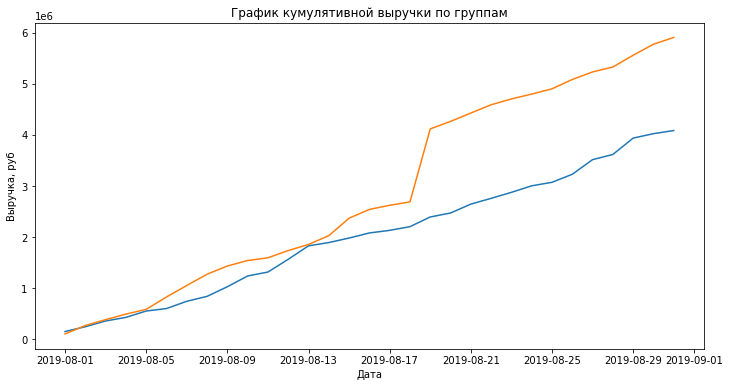

In [23]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, руб')
plt.show() 

Выручка почти равномерно увеличивается в течение всего теста. В середине теста сегмент В значительно увеличился и продолжал расти весь остаток теста. Похоже, что в сегменте В присутствуют большие заказы, которые влияют на результаты. При заключительном анализе их лучше удалить.

## 2. Построим график кумулятивного среднего чека по группам. 

In [24]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

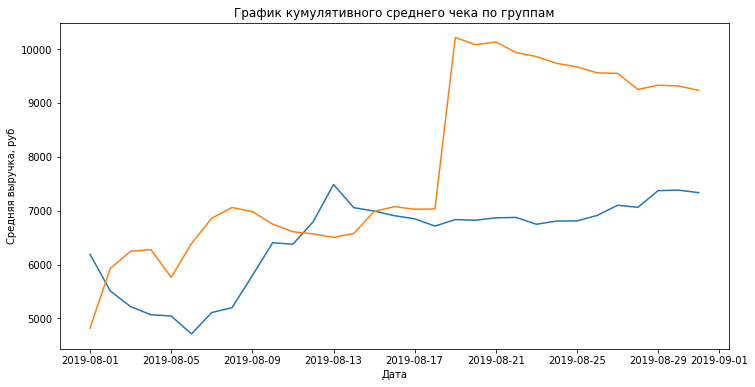

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средняя выручка, руб')
plt.show() 

В середине графика в группе В присутствует большой скачек, скорее всего он обусловлен большим заказом.

## 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

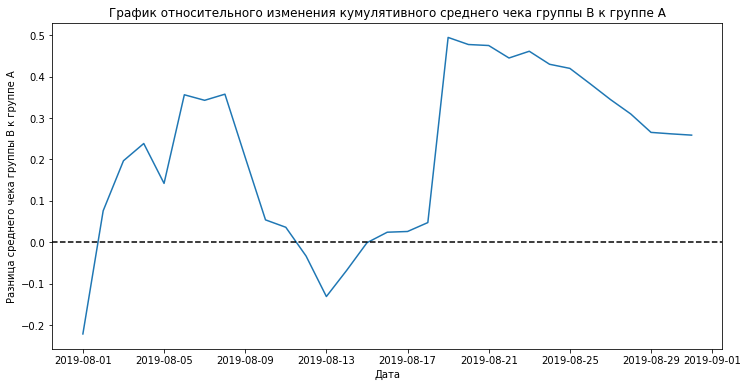

In [26]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Разница среднего чека группы B к группе A')
plt.show()

Результаты теста в несколько дат резко просели вниз, а потом резко вернулись. Скорее всего в этот период были совершены аномальные заказы.

## 4. Построим график кумулятивной конверсии по группам.

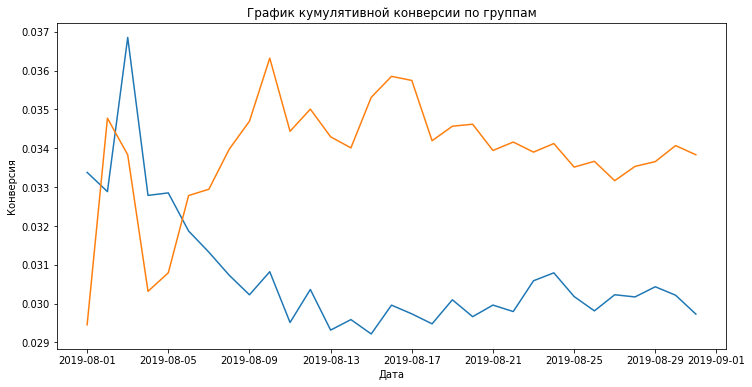

In [27]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

В начале теста сегмент А имел большую конверсию, но достаточно резко он спал вниз, а затем выровнялся. Сегмент В, наоборот, вырос, а затем выровнялся.

## 5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.

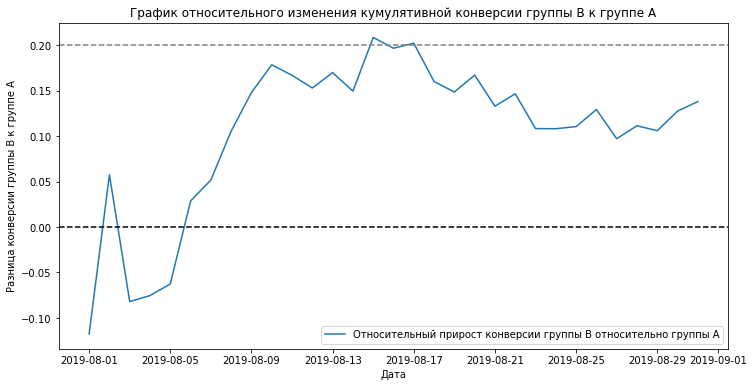

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Разница конверсии группы B к группе A')
plt.show()

С самого начала группа В проигрывала группе А, затем резко вырос, дошел до прироста в 20%, а затем плавно пошел вниз.

## 6. Построим точечный график количества заказов по пользователям.

In [30]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

In [31]:
ordersByUsers.columns = ['visitorId', 'orders']

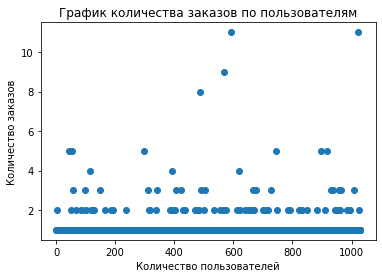

In [32]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

Большинство пользователей совершили заказ 1 раз. Пользователей совершивших больше 2 заказов очень мало, они могут быть аномалией.

## 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [33]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не больше 5% пользователей совершали больше 2 заказов, не больше 1% - больше 4. За аномальных пользователей примем пользователей, которые совершали заказ больше двух раз.

## 8. Построим точечный график стоимостей заказов.

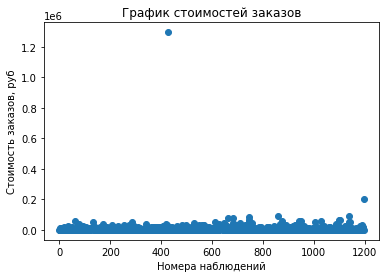

In [34]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.xlabel('Номера наблюдений')
plt.ylabel('Стоимость заказов, руб')
plt.show()

Заказов стоимостью больше 100000 рублей не так много. Есть выбросы в районе 100000 - 200000 рублей и в районе 1300000 рублей. Заказ в 1,3 млн выглядит очень аномально.

## 9. Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [35]:
np.percentile(orders['revenue'], [ 95, 99])

array([28000. , 58233.2])

Не больше, чем у 5% заказов чек дороже 28000 рублей. И не больше, чем у 1% заказов чек дороже 58233 рублей. За аномальные заказы примем заказы, чек которых выше 30000 рублей.

## 10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данными. 

Найдем пользователей, которые участвовали в двух или более группах одновременно

In [36]:
orders[orders['visitorId'].duplicated() == True]

,transactionId,visitorId,date,revenue,group
41,2594268419,237748145,2019-08-15,1090,A
91,3176574859,2742574263,2019-08-22,17868,B
95,372616894,457167155,2019-08-22,987,B
98,1962247337,2706377257,2019-08-01,7129,A
112,1638982251,3062433592,2019-08-01,8470,B
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,1290,B
1183,1458356232,963407295,2019-08-14,4940,A
1184,1329499668,2949041841,2019-08-14,10380,B
1189,4082620617,393266494,2019-08-14,31550,B


Удалим таких пользователей

In [37]:
orders = orders[orders['visitorId'].duplicated() == False]

In [38]:
orders[orders['visitorId'].duplicated() == True]

,transactionId,visitorId,date,revenue,group


Подготовим сырые данные для анализа

In [39]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [40]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Сформулируем гипотезы. 
- Нулевая: различий в конверсии между группами нет. 
- Альтернативная: различия в конверсии между группами есть.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'], где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов.

In [41]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

In [42]:
ordersByUsersA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  475 non-null    int64
 1   orders  475 non-null    int64
dtypes: int64(2)
memory usage: 11.1 KB


In [43]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули. 

In [44]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [45]:
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [46]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.016


p-value = 0.016 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можно отвергнуть в пользу альтернативной, которая говорит о том что различия в конверсии между группами есть.

In [47]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.159


Относительный проигрыш группы А равен 15.9%. 

По «сырым» данным различия в конверсии групп A и B есть.

## 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы. 
- Нулевая: различий в среднем чеке заказа между группами нет. 
- Альтернативная: различия в среднем чеке заказа между группами есть.

In [48]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

0.896


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

In [49]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.259


Средний чек группы А значительно ниже среднего чека группы В.

## 12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

In [50]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0
)

In [51]:
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах.

In [52]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [53]:
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,19,123110,20,92747,19,123110,20,92747,719,713,719,713
1,2019-08-02,17,74495,22,159293,36,197605,42,252040,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,60,310078,58,366288,507,509,1845,1803
3,2019-08-04,11,41176,14,92741,71,351254,72,459029,717,770,2562,2573
4,2019-08-05,21,102543,22,90008,92,453797,94,549037,756,707,3318,3280


In [54]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Посчитаем статистическую значимость различий в конверсии.

Сформулируем гипотезы. 
- Нулевая: различий в конверсии между группами нет. 
- Альтернативная: различия в конверсии между группами есть.

In [55]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

0.019


In [56]:
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.159


Результаты по конверсии практически не изменились, и разница между сегментами не изменилась.

## 13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы. 
- Нулевая: различий в среднем чеке заказа между группами нет. 
- Альтернативная: различия в среднем чеке заказа между группами есть.

In [57]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

0.886


In [58]:
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

-0.020


P-value незначительно уменьшился, но и разница между сегментами изменилась с относительного проигрыша группы А в 25.9% на относительный проигрыш группы В в 2.0%.

## 14. Принятие решений по результатам теста.

Результаты исследования сборе:
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- По сырым данным нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и после фильтрации аномалий.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A, но имеют тенденцию к падению.
- График различия среднего чека колеблется: это связано с аномалиями. Сделать из этого графика определённые выводы нельзя.

По результатам теста следует принять решение: Продолжить тест.